In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Random state's seed
SEED = 825

Load Dataset

In [3]:
df_train = pd.read_csv("TrainDataset2024.csv")
df_test = pd.read_excel("FinalTestDataset2024.xls")

Data Imputation

In [4]:
ID_train = df_train["ID"].reset_index(drop=True)
ID_test = df_test["ID"].reset_index(drop=True)

df_train.drop("ID", axis=1, inplace=True)
df_test.drop("ID", axis=1, inplace=True)

df_train.replace(999, np.nan, inplace=True)
df_test.replace(999, np.nan, inplace=True)

y_class = df_train["pCR (outcome)"]
y_reg = df_train["RelapseFreeSurvival (outcome)"]
df_train.drop("pCR (outcome)", axis=1, inplace=True)
df_train.drop("RelapseFreeSurvival (outcome)", axis=1, inplace=True)

In [5]:
df_train.shape, df_test.shape

((400, 118), (133, 118))

Split Clinical and MRI Features

In [6]:
X_clinical_train = df_train.iloc[:, :11]
X_mri_train = df_train.iloc[:, 11:] 

X_clinical_test = df_test.iloc[:, :11]
X_mri_test = df_test.iloc[:, 11:] 

Most Frequent

In [7]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')

y_class_1D = y_class.values.reshape(-1, 1)
y_class_1D = imputer.fit_transform(y_class_1D)
y_class = pd.Series(y_class_1D.flatten())

X_clinical_train = pd.DataFrame(imputer.fit_transform(X_clinical_train), columns=X_clinical_train.columns)
X_mri_train = pd.DataFrame(imputer.fit_transform(X_mri_train), columns=X_mri_train.columns)

X_clinical_test = pd.DataFrame(imputer.fit_transform(X_clinical_test), columns=X_clinical_test.columns)
X_mri_test = pd.DataFrame(imputer.fit_transform(X_mri_test), columns=X_mri_test.columns)

0.0    316
1.0     84
Name: count, dtype: int64


<Axes: xlabel='None', ylabel='count'>

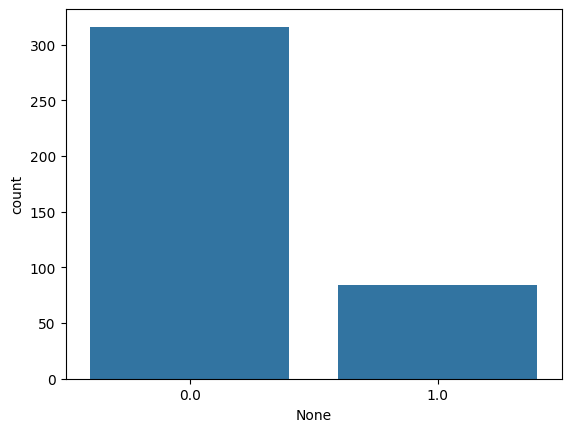

In [8]:
import seaborn as sns

print(y_class.value_counts())
sns.countplot(x=y_class)

Recursive Feature Elimination (RFE) on Clinical and MRI Features

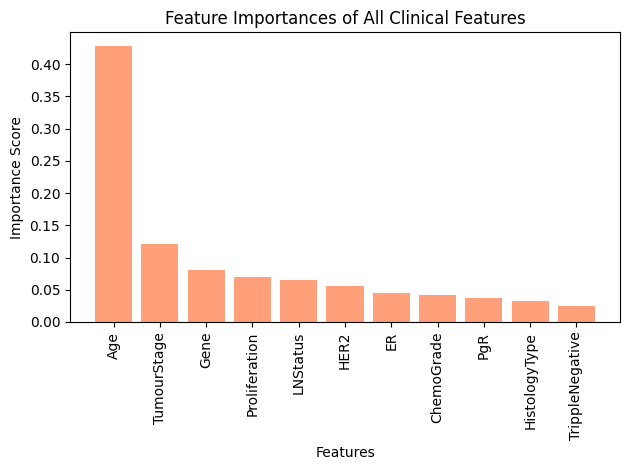

In [9]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

model_all = RandomForestClassifier(random_state=SEED)
model_all.fit(X_clinical_train, y_class)

all_importances = model_all.feature_importances_
indices = np.argsort(all_importances)[::-1]

plt.figure()
plt.title("Feature Importances of All Clinical Features")
plt.bar(X_clinical_train.columns[indices], all_importances[indices], color="lightsalmon", align="center")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [10]:
model = RandomForestClassifier(random_state=SEED)

rfecv = RFECV(estimator=model, step=5, cv=5, scoring='accuracy')

rfecv.fit(X_clinical_train, y_class)

rf_selected_features = X_clinical_train.columns[rfecv.support_]
print("Optimal Number of Features:", rfecv.n_features_)
print("Selected Features:")
print(rf_selected_features)

Optimal Number of Features: 11
Selected Features:
Index(['Age', 'ER', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade',
       'Proliferation', 'HistologyType', 'LNStatus', 'TumourStage', 'Gene'],
      dtype='object')


In [11]:
X_clinical_fs_train = X_clinical_train[rf_selected_features]
X_clinical_fs_test = X_clinical_test[rf_selected_features]

In [12]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Set True to run grid search
run_gridsearch = False
if run_gridsearch:
    param_grid = {
        'estimator__n_estimators': [50, 100, 200],      
        'estimator__max_depth': [None, 10, 20],           
        'step': [1, 2, 5],                          
        'cv': [3, 5, 10],                         
        'scoring': ['accuracy', 'roc_auc'],        
    }

    rf = RandomForestClassifier(random_state=SEED)

    rfecv = RFECV(estimator=rf)

    grid_search = GridSearchCV(rfecv, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_mri_train, y_class)

    best_params = grid_search.best_params_
    best_rfecv = grid_search.best_estimator_

    rf_selected_features = X_mri_train.columns[best_rfecv.support_]
    print("Best parameters for RFECV:", best_params)
    print("Optimal Number of Features:", best_rfecv.n_features_)
    print("Selected Features:")
    print(rf_selected_features)
run_gridsearch = False

In [13]:
rfecv.fit(X_mri_train, y_class)

rf_selected_features = X_mri_train.columns[rfecv.support_]
print("Optimal Number of Features:", rfecv.n_features_)
print("Selected Features:")
print(rf_selected_features)

Optimal Number of Features: 82
Selected Features:
Index(['original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume', 'original_firstorder_10Percentile',
       'original_firstorder_90Percentile', 'original_firstorder_Energy',
       'original_firstorder_Entropy', 'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean',
       'original_firstorder_Median', 'original_firstorder_Minimum',
       'o

In [14]:
X_mri_fs_train = X_mri_train[rf_selected_features]
X_mri_fs_test = X_mri_test[rf_selected_features]

Dimensionality Reduction on Clinical and MRI Features

Linear Discriminant Analysis (LDA)

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()

X_clinical_dr_train = lda.fit_transform(X_clinical_fs_train, y_class)
X_clinical_dr_test = lda.transform(X_clinical_fs_test)

X_mri_dr_train = lda.fit_transform(X_mri_fs_train, y_class)
X_mri_dr_test = lda.transform(X_mri_fs_test)

In [16]:
X = np.hstack((X_clinical_dr_train, X_mri_dr_train))
X_real_test = np.hstack((X_clinical_dr_test, X_mri_dr_test))

In [17]:
X.shape, type(X.shape)

((400, 2), tuple)

Z-score Distribution

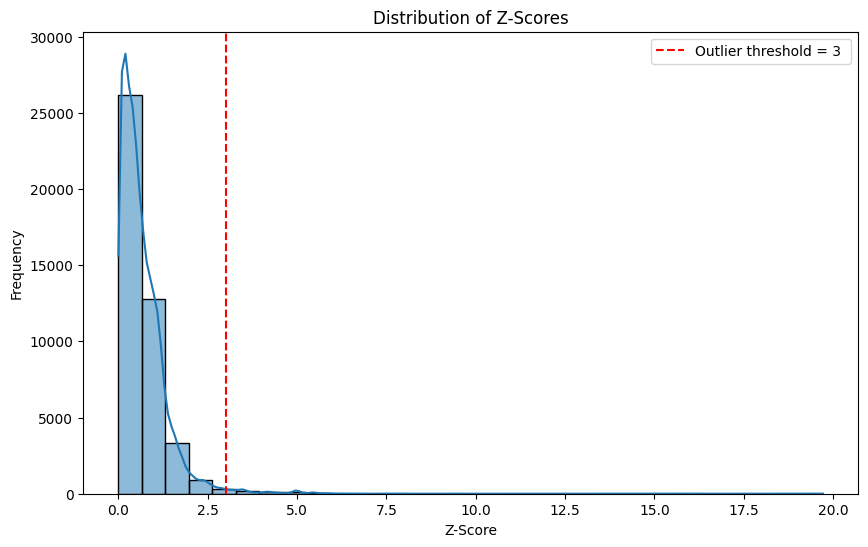

In [18]:
from scipy.stats import zscore

z_scores = np.abs(zscore(df_train))
z_scores = z_scores.to_numpy()
z_scores_flat = z_scores.flatten()

plt.figure(figsize=(10, 6))
sns.histplot(z_scores_flat, bins=30, kde=True)
plt.title("Distribution of Z-Scores")
plt.xlabel("Z-Score")
plt.ylabel("Frequency")
plt.axvline(x=3, color='r', linestyle='--', label="Outlier threshold = 3 ")
plt.legend()
plt.show()

Data Splitting

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.20, random_state=SEED, stratify=y_class)

Standardise Data (GBC doesn't need standardised data but SVM does)

In [20]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

Calculate Sample Weights

In [21]:
# Calculate class weights
class_counts = np.bincount(y_train.astype(int))
total_samples = len(y_train)
num_classes = len(class_counts)

class_weights = {}
for i, count in enumerate(class_counts):
    class_weights[i] = total_samples / (num_classes * count)

# Assign weights to each sample
sample_weights = []
for label in y_train:
    sample_weights.append(class_weights[int(label)])
sample_weights = np.array(sample_weights)

MLP

In [22]:
from sklearn.neural_network import MLPClassifier

# Set True to run grid search
run_gridsearch = False
if run_gridsearch:
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],  
        'activation': ['relu', 'tanh', 'logistic'],       
        'solver': ['adam', 'sgd'],                         
        'alpha': [0.0001, 0.001, 0.01],                   
        'learning_rate': ['constant', 'invscaling', 'adaptive'], 
        'max_iter': [200, 300, 500]                       
    }

    mlp = MLPClassifier(random_state=SEED)

    stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

    grid_search = GridSearchCV(mlp, param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_mlp = grid_search.best_estimator_

    print(f"Best parameters: {best_params}")
run_gridsearch = False

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score

mlp = MLPClassifier(
    activation='logistic',
    alpha=0.0001,
    hidden_layer_sizes=(50, 50),
    learning_rate='constant',
    max_iter=200,
    solver='adam',
    random_state=SEED
)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96        63
         1.0       0.93      0.76      0.84        17

    accuracy                           0.94        80
   macro avg       0.93      0.87      0.90        80
weighted avg       0.94      0.94      0.94        80

Confusion Matrix:
[[62  1]
 [ 4 13]]


c:\Users\Melvin\Documents\University of Nottingham\Autumn\Lab\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


ROC Curve

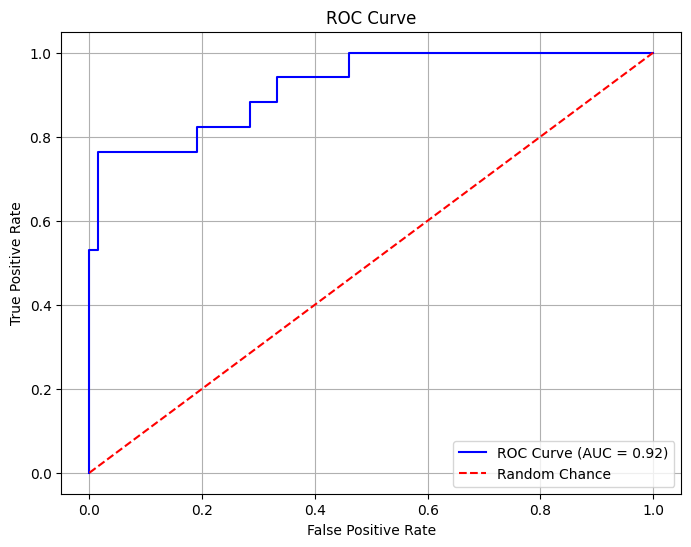

In [24]:
# Calculate ROC curve
y_pred_proba = mlp.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Chance')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [25]:
y_real_pred = mlp.predict(X_real_test)

In [26]:
y_real_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.])

In [27]:
pred_df = pd.DataFrame(y_real_pred, columns=["pCR (outcome)"])

result = pd.concat([ID_test, pred_df], axis=1)

output_file = "PCRPrediction.csv"
result.to_csv(output_file, index=False)

print(f"Predictions saved to {output_file}")

Predictions saved to PCRPrediction.csv
